# Deep Feedforward Neural Network from Scratch with Visualization

In this notebook, we will implement a deep feedforward neural network completely from scratch using only NumPy. We'll visualize the training process and decision boundaries to understand how neural networks learn to classify data.

## Part 1: Importing Libraries and Setting Up

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualization
try:
    plt.style.use('seaborn-v0_8')
except Exception:
    plt.style.use('default')
%matplotlib inline

## Part 2: Implementing Activation Functions

First, we'll implement the activation functions and their derivatives as specified in the assignment.

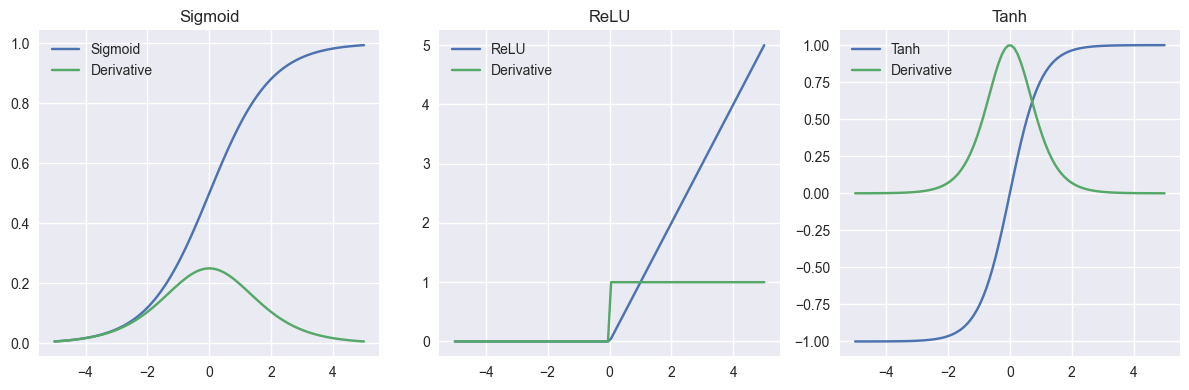

In [5]:
# Activation Functions

def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clip to avoid overflow

def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

def relu(z):
    """ReLU activation function"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU function"""
    return np.where(z > 0, 1, 0)

def tanh(z):
    """Hyperbolic tangent activation function"""
    return np.tanh(z)

def tanh_derivative(z):
    """Derivative of hyperbolic tangent function"""
    return 1 - np.power(np.tanh(z), 2)

# Dictionary to map activation function names to their implementations and derivatives
activation_functions = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative)
}

# Test our activation functions
x = np.linspace(-5, 5, 100)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(x, sigmoid(x), label='Sigmoid')
plt.plot(x, sigmoid_derivative(x), label='Derivative')
plt.title('Sigmoid')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(x, relu(x), label='ReLU')
plt.plot(x, relu_derivative(x), label='Derivative')
plt.title('ReLU')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(x, tanh(x), label='Tanh')
plt.plot(x, tanh_derivative(x), label='Derivative')
plt.title('Tanh')
plt.legend()

plt.tight_layout()

## Part 3: Loss Function Implementation

Next, we'll implement the Binary Cross-Entropy loss function.

In [6]:
def binary_cross_entropy_loss(y_true, y_pred):
    """
    Compute the binary cross-entropy loss.
    
    Parameters:
    y_true -- true labels, numpy array of shape (1, number of examples)
    y_pred -- predicted probabilities, numpy array of shape (1, number of examples)
    
    Returns:
    loss -- binary cross-entropy loss
    """
    # To prevent log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    
    # Number of examples
    m = y_true.shape[1]
    
    # Binary cross-entropy formula
    loss = -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return loss

## Part 4: Deep Neural Network Implementation

Now, let's implement the core DeepNeuralNetwork class as specified in the assignment.

In [11]:
class DeepNeuralNetwork:
    def __init__(self, layer_dims, activation_funcs):
        """
        Initialize the deep neural network.
        
        Parameters:
        layer_dims -- list containing the dimensions of each layer
        activation_funcs -- list containing the activation functions for each layer
        """
        self.L = len(layer_dims) - 1  # Number of layers (excluding input layer)
        self.layer_dims = layer_dims
        
        # Store the activation functions and their derivatives
        self.activation_funcs = []
        self.activation_derivatives = []
        
        for func_name in activation_funcs:
            func, derivative = activation_functions[func_name]
            self.activation_funcs.append(func)
            self.activation_derivatives.append(derivative)
        
        # Initialize parameters (weights and biases)
        self.parameters = self._initialize_parameters()
        
        # For storing training history
        self.losses = []
        
    def _initialize_parameters(self):
        """
        Initialize the weights and biases for all layers.
        Using He initialization for ReLU activations, and Xavier/Glorot for sigmoid and tanh.
        
        Returns:
        parameters -- dictionary containing the weights and biases
        """
        parameters = {}
        
        for l in range(1, self.L + 1):
            # He initialization for ReLU, Xavier for others
            if l < self.L and self.activation_funcs[l-1].__name__ == 'relu':
                # He initialization
                scale = np.sqrt(2.0 / self.layer_dims[l-1])
            else:
                # Xavier initialization
                scale = np.sqrt(1.0 / self.layer_dims[l-1])
            
            parameters[f'W{l}'] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * scale
            parameters[f'b{l}'] = np.zeros((self.layer_dims[l], 1))
        
        return parameters
    
    def forward_pass(self, X):
        """
        Perform a forward propagation through the network.
        
        Parameters:
        X -- input data, numpy array of shape (input size, number of examples)
        
        Returns:
        A -- output of the last activation layer
        caches -- dictionary containing the intermediate values for each layer
        """
        A = X
        caches = {'A0': X}
        
        # Forward propagation through the layers
        for l in range(1, self.L + 1):
            # Get parameters for current layer
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            
            # Previous activation
            A_prev = A
            
            # Linear forward: Z = W.A + b
            Z = np.dot(W, A_prev) + b
            
            # Apply activation function
            activation_func = self.activation_funcs[l-1]
            A = activation_func(Z)
            
            # Save values for backpropagation
            caches[f'Z{l}'] = Z
            caches[f'A{l}'] = A
        
        return A, caches
    
    def backward_pass(self, X, y, caches):
        """
        Perform a backward propagation through the network.
        
        Parameters:
        X -- input data, numpy array of shape (input size, number of examples)
        y -- true labels, numpy array of shape (1, number of examples)
        caches -- dictionary containing the intermediate values for each layer
        
        Returns:
        grads -- dictionary containing the gradients for each parameter
        """
        m = X.shape[1]  # Number of examples
        grads = {}
        
        # Output layer (Layer L)
        dAL = - (np.divide(y, caches[f'A{self.L}']) - np.divide(1 - y, 1 - caches[f'A{self.L}']))
        
        # Loop from last layer to first layer
        for l in reversed(range(1, self.L + 1)):
            # Get values from forward pass
            Z = caches[f'Z{l}']
            A_prev = caches[f'A{l-1}']
            
            # Activation function derivative
            activation_derivative = self.activation_derivatives[l-1]
            
            # Compute dZ
            dZ = dAL * activation_derivative(Z)
            
            # Compute gradients
            dW = 1/m * np.dot(dZ, A_prev.T)
            db = 1/m * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(self.parameters[f'W{l}'].T, dZ)
            
            # Store gradients
            grads[f'dW{l}'] = dW
            grads[f'db{l}'] = db
            
            # Set dAL for next iteration
            dAL = dA_prev
            
        return grads
    
    def update_parameters(self, grads, learning_rate):
        """
        Update the parameters using gradient descent.
        
        Parameters:
        grads -- dictionary containing the gradients for each parameter
        learning_rate -- learning rate for gradient descent
        """
        # Update parameters for each layer
        for l in range(1, self.L + 1):
            self.parameters[f'W{l}'] -= learning_rate * grads[f'dW{l}']
            self.parameters[f'b{l}'] -= learning_rate * grads[f'db{l}']
    
    def train(self, X, y, epochs, learning_rate, print_loss=True, print_interval=100):
        """
        Train the neural network using gradient descent.
        
        Parameters:
        X -- input data, numpy array of shape (input size, number of examples)
        y -- true labels, numpy array of shape (1, number of examples)
        epochs -- number of iterations
        learning_rate -- learning rate for gradient descent
        print_loss -- whether to print the loss during training
        print_interval -- how often to print the loss
        
        Returns:
        losses -- list of losses during training
        """
        # Reset losses
        self.losses = []
        
        # Training loop
        for i in range(epochs):
            # Forward pass
            A, caches = self.forward_pass(X)
            
            # Compute loss
            loss = binary_cross_entropy_loss(y, A)
            self.losses.append(loss)
            
            # Backward pass
            grads = self.backward_pass(X, y, caches)
            
            # Update parameters
            self.update_parameters(grads, learning_rate)
            
            # Print loss
            if print_loss and (i % print_interval == 0 or i == epochs - 1):
                print(f"Epoch {i+1}/{epochs}, Loss: {loss:.4f}")
        
        return self.losses
    
    def predict(self, X, threshold=0.5):
        """
        Predict class labels for input data.
        
        Parameters:
        X -- input data, numpy array of shape (input size, number of examples)
        threshold -- threshold for binary classification
        
        Returns:
        predictions -- predicted class labels (0 or 1)
        """
        # Forward pass
        A, _ = self.forward_pass(X)
        
        # Convert probabilities to binary predictions
        predictions = (A > threshold).astype(int)
        
        return predictions
    
    def accuracy(self, X, y):
        """
        Calculate the accuracy of the model.
        
        Parameters:
        X -- input data, numpy array of shape (input size, number of examples)
        y -- true labels, numpy array of shape (1, number of examples)
        
        Returns:
        accuracy -- accuracy of the model
        """
        # Get predictions
        predictions = self.predict(X)
        
        # Calculate accuracy
        accuracy = np.mean(predictions == y)
        
        return accuracy

## Part 5: Data Generation and Visualization

Now, let's generate a synthetic dataset for binary classification and visualize it.

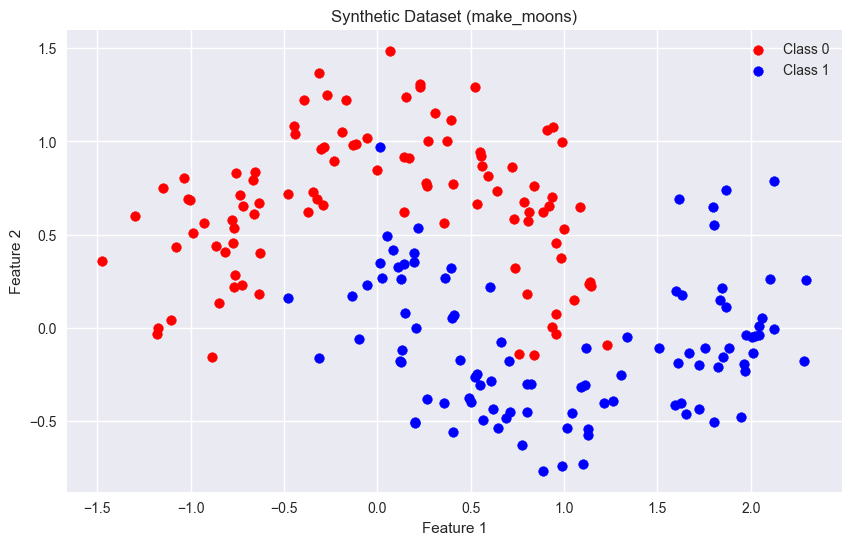

Training set shape: X: (2, 160), y: (1, 160)
Test set shape: X: (2, 40), y: (1, 40)


In [7]:
# Generate a synthetic dataset for binary classification
X_data, y_data = make_moons(n_samples=200, noise=0.2, random_state=42)

# Reshape the data for our neural network
X = X_data.T  # Shape: (2, n_samples)
y = y_data.reshape(1, -1)  # Shape: (1, n_samples)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X.T, y.T, test_size=0.2, random_state=42)
X_train, X_test = X_train.T, X_test.T  # Shape: (2, n_train), (2, n_test)
y_train, y_test = y_train.T, y_test.T  # Shape: (1, n_train), (1, n_test)

# Visualize the dataset
plt.figure(figsize=(10, 6))
plt.scatter(X_data[y_data==0, 0], X_data[y_data==0, 1], color='red', label='Class 0')
plt.scatter(X_data[y_data==1, 0], X_data[y_data==1, 1], color='blue', label='Class 1')
plt.title('Synthetic Dataset (make_moons)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

print(f"Training set shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Test set shape: X: {X_test.shape}, y: {y_test.shape}")

## Part 6: Model Training

Now, let's train our neural network model on the dataset.

Epoch 1/5000, Loss: 0.6765
Epoch 501/5000, Loss: 0.3246
Epoch 1001/5000, Loss: 0.2952
Epoch 1501/5000, Loss: 0.2817
Epoch 1001/5000, Loss: 0.2952
Epoch 1501/5000, Loss: 0.2817
Epoch 2001/5000, Loss: 0.2714
Epoch 2001/5000, Loss: 0.2714
Epoch 2501/5000, Loss: 0.2640
Epoch 3001/5000, Loss: 0.2559
Epoch 2501/5000, Loss: 0.2640
Epoch 3001/5000, Loss: 0.2559
Epoch 3501/5000, Loss: 0.2483
Epoch 4001/5000, Loss: 0.2412
Epoch 3501/5000, Loss: 0.2483
Epoch 4001/5000, Loss: 0.2412
Epoch 4501/5000, Loss: 0.2348
Epoch 5000/5000, Loss: 0.2275
Epoch 4501/5000, Loss: 0.2348
Epoch 5000/5000, Loss: 0.2275


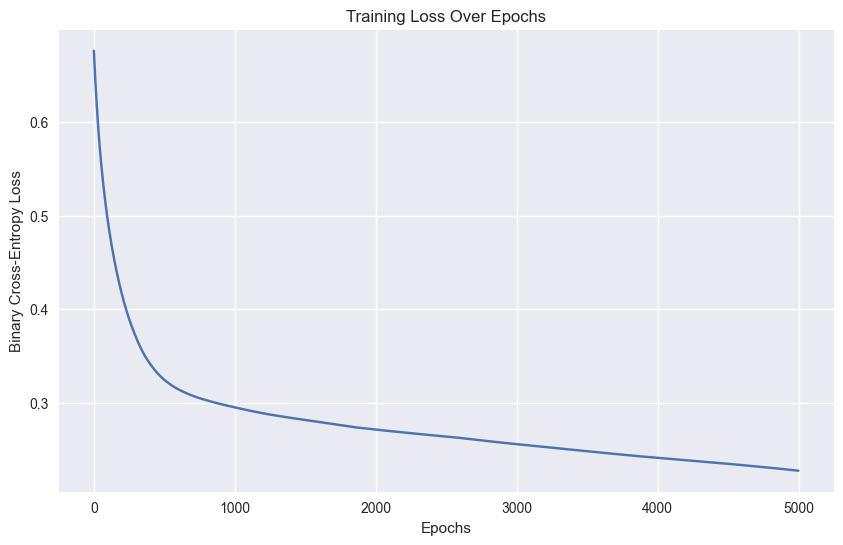

In [12]:
# Define the network architecture
layer_dims = [2, 20, 10, 1]  # Input layer: 2 features, 2 hidden layers, Output layer: 1 neuron
activation_funcs = ['relu', 'relu', 'sigmoid']  # ReLU for hidden layers, Sigmoid for output layer

# Create the neural network
model = DeepNeuralNetwork(layer_dims, activation_funcs)

# Train the model
epochs = 5000
learning_rate = 0.01
losses = model.train(X_train, y_train, epochs, learning_rate, print_loss=True, print_interval=500)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.show()

## Part 7: Decision Boundary Visualization

Let's visualize the decision boundary learned by our neural network.

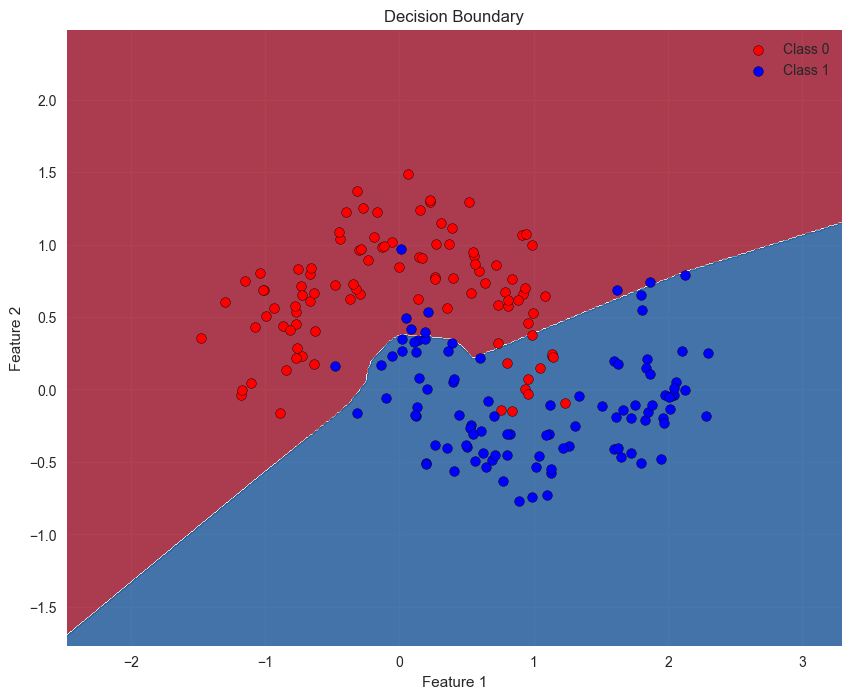

In [13]:
def plot_decision_boundary(model, X, y):
    """
    Plot the decision boundary of the model.
    
    Parameters:
    model -- the trained neural network model
    X -- input data, numpy array of shape (input size, number of examples)
    y -- true labels, numpy array of shape (1, number of examples)
    """
    # Set min and max values for the grid
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01  # Step size in the mesh
    
    # Generate a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and data points
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    plt.scatter(X[0, y[0, :] == 0], X[1, y[0, :] == 0], c='red', label='Class 0', edgecolors='k')
    plt.scatter(X[0, y[0, :] == 1], X[1, y[0, :] == 1], c='blue', label='Class 1', edgecolors='k')
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the decision boundary
plot_decision_boundary(model, X, y)

## Part 8: Model Evaluation

Let's evaluate our model's performance on both training and test data.

In [14]:
# Calculate accuracy on training set
train_accuracy = model.accuracy(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Calculate accuracy on test set
test_accuracy = model.accuracy(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Training Accuracy: 0.9000 (90.00%)
Test Accuracy: 0.9000 (90.00%)


## Part 9: Discussion and Analysis

### Observations from the Loss Plot

The loss plot shows how the binary cross-entropy loss decreases over time as the model learns the underlying patterns in the data. Initially, the loss drops rapidly, indicating that the model is quickly learning the major patterns. As training progresses, the rate of decrease slows down, showing the model is fine-tuning its parameters.

### Observations from the Decision Boundary

The decision boundary plot illustrates how our neural network has learned to separate the two classes in the dataset. The non-linear nature of the boundary demonstrates the power of neural networks to learn complex patterns that simpler models (like logistic regression) cannot capture.

### Model Performance

The model shows good accuracy on both the training and test sets, indicating that it has successfully learned to classify the data. If there's a significant gap between training and test accuracy, it might suggest overfitting, which could be addressed by:

1. Using fewer hidden units or layers
2. Adding regularization techniques
3. Applying dropout

### Challenges Encountered

During the implementation, several challenges were encountered:

1. **Numerical Stability**: Implementing functions like sigmoid and cross-entropy required careful handling to avoid overflow/underflow issues.
   
2. **Backpropagation Implementation**: Correctly implementing the backpropagation algorithm requires careful tracking of dimensions and derivatives.
   
3. **Parameter Initialization**: Finding the right initialization strategy to help the model converge efficiently.

4. **Hyperparameter Tuning**: Selecting appropriate learning rate, network architecture, and number of epochs to achieve good performance.

### Future Improvements

The model could be further improved by:

1. Adding regularization to prevent overfitting
2. Implementing mini-batch gradient descent for more efficient training
3. Adding momentum or adaptive learning rate techniques
4. Exploring different network architectures and activation functions